# Python translation of Carbon Budgets from Lauderdale et al 2016

In [1]:
#import cmocean    as cm
import matplotlib as mp
import numpy      as np
import xarray     as xr
import datetime
import os
import mitgcm_tools
import warnings
import xgcm

from xmitgcm import open_mdsdataset
from matplotlib import pyplot    as plt
from matplotlib import animation as pla
#plt.rcParams.update({'font.size': 15})
plt.rcParams['animation.html'] = 'html5'

def label_axes(axarray,ignore=None,label_columns=False):
    import string      as st
    m=0
    
    if label_columns:
        axarray=np.transpose(axarray)
    
    for n, ax in enumerate(axarray.flat):
        if ignore is not None and n in ignore:
            m+=1
            continue
        else:
            ax.text(-0.1, 1.05, st.ascii_uppercase[n-m], transform=ax.transAxes, 
                    size=20, weight='bold')
            
plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)            
            
from dask.distributed import Client
client = Client()
client

2022-09-21 09:43:34,981 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/myoungs/dask-worker-space/worker-59t13rh9', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 9
Total threads: 72,Total memory: 125.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38547,Workers: 9
Dashboard: http://127.0.0.1:8787/status,Total threads: 72
Started: Just now,Total memory: 125.47 GiB
Comm: tcp://127.0.0.1:44867,Total threads: 8
Dashboard: http://127.0.0.1:46211/status,Memory: 13.94 GiB
Nanny: tcp://127.0.0.1:42847,


## Methods, constants, and conversions

In [2]:
kave_method='arb_depth'
kave=50 # arbitrary depth in metres

cp = 3985.0 # Heat capacity J kg-1 K-1
KDOPRemin=1/(6*30*86400) # six months in s-1
seconds_per_year=360.*86400
rhoconst=1024.5
perl_2_perkg=1000/rhoconst # e.g. mol l-1 * 1000 l m-3 * 1/rho m3 kg-1 -> mol kg-1
perm3_2_perl = 1.0/1000 #e.g. mol m-3 * 1/1000 m3 l-1 -> mol l-1
molperm3_2_umolperkg=1e6/rhoconst
umolperkgmpers_2_molperm2peryr = rhoconst*seconds_per_year*1e-6

# set Redfield ratios for organic matter
Rcn   = 117/16
Rcp   = 117
Rpo   =-1/170
Rno   =-16/170
Rnp   = 16/1
Rcaco3= 7e-2 # Inorganic/organic carbon rain ratio
Rsip  = 15

## Load in data

In [3]:
path = '/glade/p/univ/umit0025/newcarbon/dop_mean/'

ds = open_mdsdataset(path,prefix=['DIAG','DIAGSurf','DIAGTracer'],geometry='cartesian')#,iters=[71744400,72007200])
                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])

#grid,xgrid=mitgcm_tools.loadgrid(path) #+'grid.glob.nc')
#grid=grid.transpose('XC','XG','YC','YG','ZC','ZG','ZL','ZR')
#grid.close()

#data_parms = mitgcm_tools.getparm(path+'data') 
#grid['iter'] = np.arange(data_parms['niter0'],
#                              data_parms['niter0']+data_parms['ntimesteps']+data_parms['tavefreq']/data_parms['deltatclock'],
#                              data_parms['tavefreq']/data_parms['deltatclock'])
#data_pkg   = mitgcm_tools.getparm(path+'data.pkg') 

#if data_pkg['usegmredi']:
#    data_gmr = mitgcm_tools.getparm(path+'data.gmredi')     
    
#if data_pkg['useptracers']:
#    data_ptr = mitgcm_tools.getparm(path+'data.ptracers') 

    
#if data_pkg['usegchem']:
#    data_gch = mitgcm_tools.getparm(path+'data.gchem') 
#    if data_gch['usedic']:
#        data_dic = mitgcm_tools.getparm(path+'data.dic') 

#if data_pkg['usekpp']:
#    data_kpp = mitgcm_tools.getparm(path+'data.kpp') 
#    kppdiag= mitgcm_tools.open_ncfile(path+'kppDiag.*.glob.nc',
#                                            strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
#    kppdiag.close()

Text(0.5, 0, 'time')

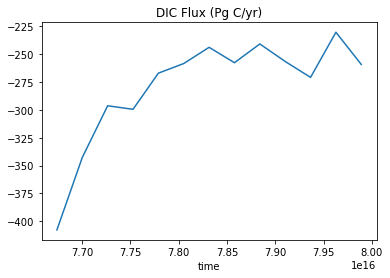

In [7]:
ds
flux = ds.DICCFLX
plt.figure()
(ds.DICCFLX.sum(dim = 'XC').sum(dim = 'YC')*12*3600*24*365/1e15*1000*ds.dyG[0,0]*ds.dxG[0,0]*10).plot()
plt.title('DIC Flux (Pg C/yr)')
plt.xlabel('time')
  

In [4]:
hdiff_ADV_dic   = grid.diff_2d_vector({'X': ds.ADVxTr01[-8:], 'Y': ds.ADVyTr01[-8:]}, boundary='fill')
dic_adv_horz =-(((hdiff_ADV_dic['X']+hdiff_ADV_dic['Y'])*ds.drF)/ds.rA/ds.drF/ds.hFacC).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)
dic_adv_vert =((grid.diff(ds.ADVrTr01[-8:],'Z',boundary='fill')*ds.drF)/ds.rA/ds.drF/ds.hFacC).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)

hdiff_DIF_dic   = grid.diff_2d_vector({'X': ds.DFxETr01[-8:], 'Y': ds.DFyETr01[-8:]}, boundary='fill')
dic_dif_horz =-(((hdiff_DIF_dic['X']+hdiff_DIF_dic['Y'])*ds.drF)/ds.rA/ds.drF/ds.hFacC).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)
dic_dif_vert =((grid.diff(ds.DFrETr01[-8:]+ds.DFrITr01[-8:],'Z',boundary='fill')*ds.drF)/ds.rA/ds.drF/ds.hFacC).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)


dt = 1.577e8
#dic_surf_flux = ds.DICVCFLX*ds.maskC.isel(Z=0)
ddicdt       = ((ds.TRAC01[-8:].diff('time')*ds.drF).sel(Z=slice(0,-kave)).sum("Z")/dt)*ds.maskC.isel(Z=0)

dic_bio_flux  = (Rcp*(-ds.DICBIOA[-8:]+ds.DICPFLUX[-8:]+ds.DICRDOP[-8:])*ds.drF).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)
dic_carb_flux = ((ds.DICCARB[-8:])*ds.drF).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)

# Air-sea CO2 fluxes
dic_co2_flux = ds.DICCFLX[-8:]*ds.maskC.isel(Z=0)#/ds.drF.sel(Z=-5)
#dic_co2_tend = ((ds.DICTFLX)*ds.drF).sel(Z=slice(0,-kave)).sum("Z")*ds.maskC.isel(Z=0)

# The budget residual
dic_tot_budget = dic_adv_horz + dic_adv_vert + dic_dif_horz + dic_dif_vert + ddicdt + \
                dic_co2_flux + dic_bio_flux + dic_carb_flux #removed dic_surf_flux

streamlines = (ds.UVEL[:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')

AttributeError: 'dict' object has no attribute 'transpose'

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

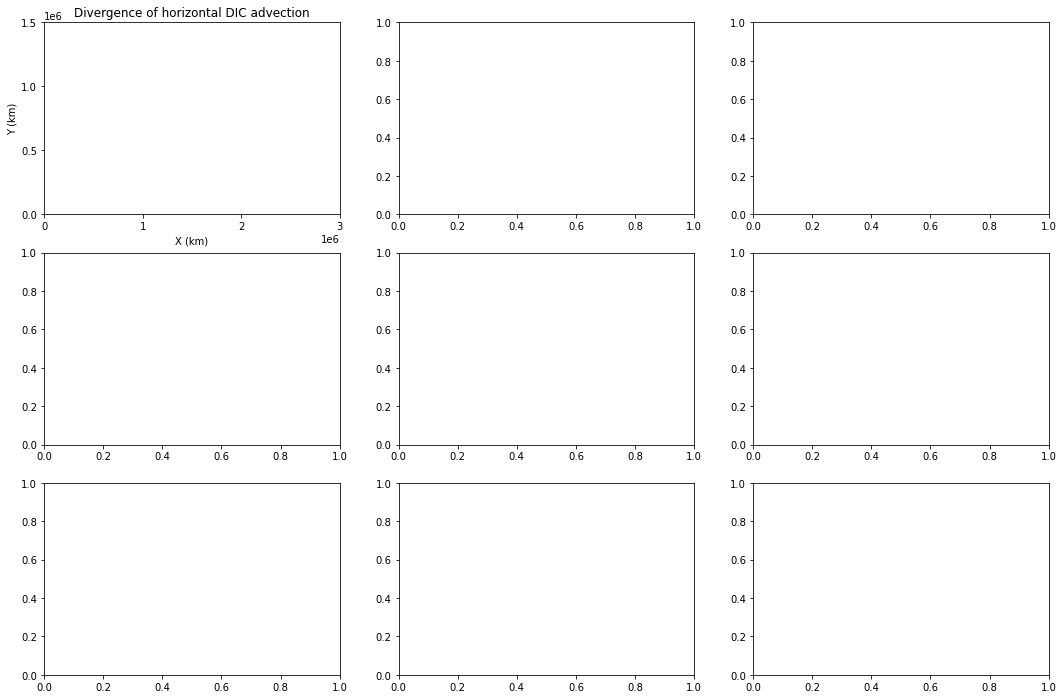

In [5]:
with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f3,f3ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f3.patch.set_facecolor('None')
    f3cax = f3ax.copy()
    f3cbar= f3ax.copy()
    cfac=1000/10*3600*24*365
    ctargs={"levels":np.arange(-1000,1001,10),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-50000,51000,1000),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-1000,1005,250),"extend":"both"}
    cbarg2={"ticks" :np.arange(-50000,55000,10000),"extend":"both"}
    axargs={"xlabel":"X (km)","ylabel":"Y (km)","xticks":np.arange(0,4000000,1000000),"yticks":np.arange(0,2000000,500000),
            "yticklabels":[0,500,1000,1500,2000],"xticklabels":[0,1000,2000,3000,4000],"facecolor":"black"}


    f3ax  [0,0].set(title="Divergence of horizontal DIC advection",**axargs)
    f3cax [0,0]=f3ax[0,0].contourf(ds.XC,ds.YC,cfac*dic_adv_horz.mean("time",skipna=True),**ctarg2)
    for a in f3ax[0,0].collections:
        a.set_edgecolor("face")
    f3cbar[0,0]=f3.colorbar(f3cax[0,0],ax=f3ax[0,0],**cbarg2)
    f3cbar[0,0].solids.set_edgecolor("face")
    f3ax[0,0].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [0,1].set(title="Divergence of vertical DIC advection",**axargs)
    f3cax [0,1]=f3ax[0,1].contourf(ds.XC,ds.YC,cfac*dic_adv_vert.mean("time",skipna=True),**ctarg2)
    for a in f3ax[0,1].collections:
        a.set_edgecolor("face")
    f3cbar[0,1]=f3.colorbar(f3cax[0,1],ax=f3ax[0,1],**cbarg2)
    f3cbar[0,1].solids.set_edgecolor("face")
    f3ax[0,1].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [0,2].set(title="Divergence of net DIC advection",**axargs)
    f3cax [0,2]=f3ax[0,2].contourf(ds.XC,ds.YC,cfac*(dic_adv_horz+dic_adv_vert).mean("time",skipna=True),**ctargs)
    for a in f3ax[0,2].collections:
        a.set_edgecolor("face")
    f3cbar[0,2]=f3.colorbar(f3cax[0,2],ax=f3ax[0,2],**cbargs)
    f3cbar[0,2].solids.set_edgecolor("face")
    f3ax[0,2].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [1,0].set(title="Divergence of vertical DIC diffusion",**axargs)
    f3cax [1,0]=f3ax[1,0].contourf(ds.XC,ds.YC,cfac*dic_dif_vert.mean("time",skipna=True),**ctargs)
    for a in f3ax[1,0].collections:
        a.set_edgecolor("face")
    f3cbar[1,0]=f3.colorbar(f3cax[1,0],ax=f3ax[1,0],**cbargs)
    f3cbar[1,0].solids.set_edgecolor("face")
    f3ax[1,0].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [1,1].set(title="Surface flux of DIC due to CO$_2$ exchange",**axargs)
    f3cax [1,1]=f3ax[1,1].contourf(ds.XC,ds.YC,cfac*dic_co2_flux.mean("time",skipna=True),**ctargs)
    for a in f3ax[1,1].collections:
        a.set_edgecolor("face")
    f3cbar[1,1]=f3.colorbar(f3cax[1,1],ax=f3ax[1,1],**cbargs)
    f3cbar[1,1].solids.set_edgecolor("face")
    f3ax[1,1].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [1,2].set(title="Biological activity of DIC",**axargs)                     
    f3cax [1,2]=f3ax[1,2].contourf(ds.XC,ds.YC,cfac*(dic_bio_flux+dic_carb_flux).mean("time",skipna=True),**ctargs)
    for a in f3ax[1,2].collections:
        a.set_edgecolor("face")
    f3cbar[1,2]=f3.colorbar(f3cax[1,2],ax=f3ax[1,2],**cbargs)
    f3cbar[1,2].solids.set_edgecolor("face")
    f3ax[1,2].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [2,0].set(title="Divergence of horizontal DIC diffusion",**axargs)
    f3cax [2,0]=f3ax[2,0].contourf(ds.XC,ds.YC,cfac*(dic_dif_horz).mean("time",skipna=True),**ctargs)
    for a in f3ax[2,0].collections:
        a.set_edgecolor("face")
    f3cbar[2,0]=f3.colorbar(f3cax[2,0],ax=f3ax[2,0],**cbargs)
    f3cbar[2,0].solids.set_edgecolor("face")
    f3ax[2,0].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [2,1].set(title="Tendency of DIC",**axargs)
    f3cax [2,1]=f3ax[2,1].contourf(ds.XC,ds.YC,cfac*ddicdt.mean("time",skipna=True),**ctargs)
    for a in f3ax[2,1].collections:
        a.set_edgecolor("face")
    f3cbar[2,1]=f3.colorbar(f3cax[2,1],ax=f3ax[2,1],**cbargs)
    f3cbar[2,1].solids.set_edgecolor("face")
    f3ax[2,1].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [2,2].set(title="DIC budget residual",**axargs)
    f3cax [2,2]=f3ax[2,2].contourf(ds.XC,ds.YC,cfac*dic_tot_budget.mean("time",skipna=True),**ctargs)
    for a in f3ax[2,2].collections:
        a.set_edgecolor("face")
    f3cbar[2,2]=f3.colorbar(f3cax[2,2],ax=f3ax[2,2],**cbargs)
    f3cbar[2,2].solids.set_edgecolor("face")
    f3ax[2,2].contour(ds.XC, ds.YC,streamlines,levels = 8,colors = 'black',linewidth=1,linestyles='solid')
                     
    # Can adjust the subplot size
    f3.subplots_adjust(hspace=0.3) 
    f3.suptitle("Terms of the DIC Budget [mmol m$^{-3}$ yr$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f3ax)
    
    plt.savefig(plot_dir+'CarbonBudget'+'.eps',bbox_inches='tight')

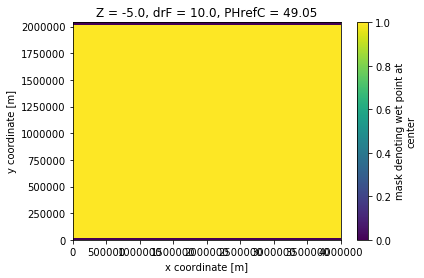

In [5]:
ds.maskC.isel(Z=0).plot()

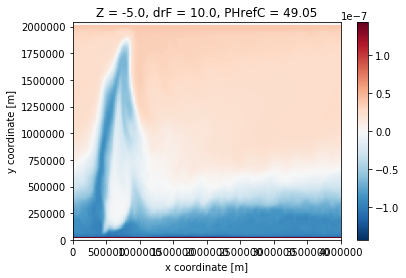

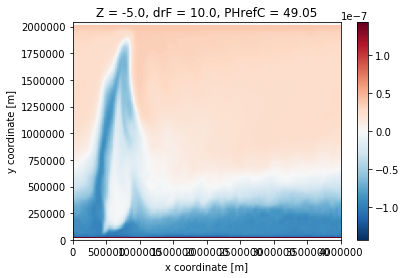

In [7]:
dic_co2_flux = ds.DICCFLX*ds.maskC.isel(Z=0)
dic_co2_tend = ((ds.DICTFLX)*ds.drF.isel(Z=0))*ds.maskC.isel(Z=0)

plt.figure()
dic_co2_tend.mean(dim='time').plot()
plt.figure()
dic_co2_flux.mean(dim='time').plot()
#plt.figure()
#(dic_adv_horz+dic_adv_vert+dic_co2_flux+dic_dif_horz+dic_dif_vert+ddicdt+dic_surf_flux).mean("time").plot()

#print(np.array(dic_surf_flux.mean(dim='time')))

/glade/u/home/myoungs/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
/glade/u/home/myoungs/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'
/glade/u/home/myoungs/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/glade/u/home/myoungs/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The following kwargs were not used by contour: 'linewidth'


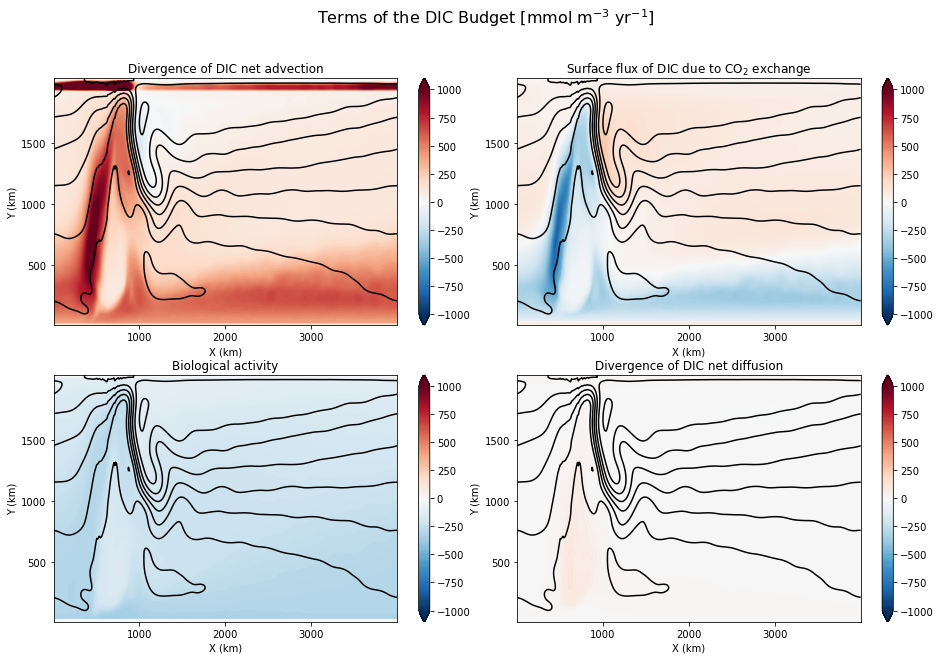

In [16]:


with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f3,f3ax=plt.subplots(figsize=(16, 10),ncols=2,nrows=2)
    f3.patch.set_facecolor('None')
    f3cax = f3ax.copy()
    f3cbar= f3ax.copy()
    cfac=1000/10*3600*24*365
    ctargs={"levels":np.arange(-1000,1001,10),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-50000,51000,1000),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-1000,1005,250),"extend":"both"}
    cbarg2={"ticks" :np.arange(-50000,55000,10000),"extend":"both"}
    axargs={"xlabel":"X (km)","ylabel":"Y (km)","xticks":np.arange(0,4000000,1000000),"yticks":np.arange(0,2000000,500000),
            "yticklabels":[0,500,1000,1500,2000],"xticklabels":[0,1000,2000,3000,4000],"facecolor":"black"}

    f3ax  [0,0].set(title="Divergence of DIC net advection",**axargs)
    f3cax [0,0]=f3ax[0,0].contourf(ds.XC,ds.YC,cfac*(dic_adv_horz+dic_adv_vert).mean("time",skipna=True),**ctargs)
    for a in f3ax[0,0].collections:
        a.set_edgecolor("face")
    f3cbar[0,0]=f3.colorbar(f3cax[0,0],ax=f3ax[0,0],**cbargs)
    f3cbar[0,0].solids.set_edgecolor("face")
    f3ax[0,0].contour(ds.XC, ds.YC,streamlines,levels = 7,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [1,0].set(title="Biological activity",**axargs)
    f3cax [1,0]=f3ax[1,0].contourf(ds.XC,ds.YC,cfac*(dic_bio_flux+dic_carb_flux).mean("time",skipna=True),**ctargs)
    for a in f3ax[1,0].collections:
        a.set_edgecolor("face")
    f3cbar[1,0]=f3.colorbar(f3cax[1,0],ax=f3ax[1,0],**cbargs)
    f3cbar[1,0].solids.set_edgecolor("face")
    f3ax[1,0].contour(ds.XC, ds.YC,streamlines,levels = 7,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [0,1].set(title="Surface flux of DIC due to CO$_2$ exchange",**axargs)
    f3cax [0,1]=f3ax[0,1].contourf(ds.XC,ds.YC,cfac*(dic_co2_flux).mean("time",skipna=True),**ctargs)
    for a in f3ax[0,1].collections:
        a.set_edgecolor("face")
    f3cbar[0,1]=f3.colorbar(f3cax[0,1],ax=f3ax[0,1],**cbargs)
    f3cbar[0,1].solids.set_edgecolor("face")
    f3ax[0,1].contour(ds.XC, ds.YC,streamlines,levels = 7,colors = 'black',linewidth=1,linestyles='solid')
    f3ax  [1,1].set(title="Divergence of DIC net diffusion",**axargs)
    f3cax [1,1]=f3ax[1,1].contourf(ds.XC,ds.YC,cfac*(dic_dif_vert+dic_dif_horz).mean("time",skipna=True),**ctargs)
    for a in f3ax[1,1].collections:
        a.set_edgecolor("face")
    f3cbar[1,1]=f3.colorbar(f3cax[1,1],ax=f3ax[1,1],**cbargs)
    f3cbar[1,1].solids.set_edgecolor("face")
    f3ax[1,1].contour(ds.XC, ds.YC,streamlines,levels = 7,colors = 'black',linewidth=1,linestyles='solid')
    #f3ax  [1,1].set(title="Surface flux of DIC due to CO$_2$ exchange",**axargs)
    #f3cax [1,1]=f3ax[1,1].contourf(ds.XC,ds.YC,cfac*dic_co2_flux.mean("time",skipna=True),**ctargs)
    #for a in f3ax[1,1].collections:
    #    a.set_edgecolor("face")
    #f3cbar[1,1]=f3.colorbar(f3cax[1,1],ax=f3ax[1,1],**cbargs)
    #f3cbar[1,1].solids.set_edgecolor("face")
    #f3ax  [1,2].set(title="Biological activity of DIC",**axargs)                     
    #f3cax [1,2]=f3ax[1,2].contourf(ds.XC,ds.YC,cfac*(dic_bio_flux+dic_carb_flux).mean("time",skipna=True),**ctargs)
    #for a in f3ax[1,2].collections:
    #    a.set_edgecolor("face")
    #f3cbar[1,2]=f3.colorbar(f3cax[1,2],ax=f3ax[1,2],**cbargs)
    #f3cbar[1,2].solids.set_edgecolor("face")
    #f3ax  [2,0].set(title="Divergence of horizontal DIC diffusion",**axargs)
    #f3cax [2,0]=f3ax[2,0].contourf(ds.XC,ds.YC,cfac*(dic_dif_horz).mean("time",skipna=True),**ctargs)
    #for a in f3ax[2,0].collections:
    #    a.set_edgecolor("face")
    #f3cbar[2,0]=f3.colorbar(f3cax[2,0],ax=f3ax[2,0],**cbargs)
    #f3cbar[2,0].solids.set_edgecolor("face")
    #f3ax  [2,1].set(title="Tendency of DIC",**axargs)
    #f3cax [2,1]=f3ax[2,1].contourf(ds.XC,ds.YC,cfac*ddicdt.mean("time",skipna=True),**ctargs)
    #for a in f3ax[2,1].collections:
     #   a.set_edgecolor("face")
    #f3cbar[2,1]=f3.colorbar(f3cax[2,1],ax=f3ax[2,1],**cbargs)
    #f3cbar[2,1].solids.set_edgecolor("face")
    #f3ax  [2,2].set(title="DIC budget residual",**axargs)
    ##f3cax [2,2]=f3ax[2,2].contourf(ds.XC,ds.YC,cfac*dic_tot_budget.mean("time",skipna=True),**ctargs)
    #for a in f3ax[2,2].collections:
    #    a.set_edgecolor("face")
    #f3cbar[2,2]=f3.colorbar(f3cax[2,2],ax=f3ax[2,2],**cbargs)
    #f3cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f3.subplots_adjust(hspace=0.2) 
    f3.subplots_adjust(wspace = 0.08)
    f3.suptitle("Terms of the DIC Budget [mmol m$^{-3}$ yr$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    #label_axes(f3ax)